In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc,rcParams
import itertools
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
num_feat_colors = ['#781C68', '#319DA0']
metric_colors = ['#393E46','#4649FF','#54B435']
cat_feat_colors = ['#FFB6B9', '#FAE3D9', '#BBDED6', '#61C0BF', "#CCA8E9", "#F67280"]

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#from catboost import CatBoostClassifier
#from lightgbm import LGBMClassifier
#from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import f1_score,accuracy_score,roc_auc_score, confusion_matrix

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Businnes Problem
- It is desirable to develop a machine learning model that can predict customers who will leave the company. You are expected to perform the necessary data analysis and feature engineering steps before developing the model.

In [14]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [2]:
df = pd.read_csv("Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [20]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

- Let's take a quick look data

In [4]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=False)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df).sort_values(by="Ratio", ascending=False)
    return missing_df


def check_df(dataframe, head=5, tail=5):
    print("*" * 70)
    print(" Shape ".center(70, "*"))
    print("*" * 70)
    print(dataframe.shape)

    print("*" * 70)
    print(" Types ".center(70, "*"))
    print("*" * 70)
    print(dataframe.dtypes)

    print("*" * 70)
    print(" Head ".center(70, "*"))
    print("*" * 70)
    print(dataframe.head(head))

    print("*" * 70)
    print(" Tail ".center(70, "*"))
    print("*" * 70)
    print(dataframe.tail(tail))

    print("*" * 70)
    print(" NA ".center(70, "*"))
    print("*" * 70)
    print(missing_values_analysis(dataframe))

    print("*" * 70)
    print(" Quantiles ".center(70, "*"))
    print("*" * 70)
    print(dataframe.describe([.01, .05, .1, .5, .9, .95, .99]).T)

    print("*" * 70)
    print(" Duplicate Rows ".center(70, "*"))
    print("*" * 70)
    print(dataframe.duplicated().sum())

    print("*" * 70)
    print(" Uniques ".center(70, "*"))
    print("*" * 70)
    print(dataframe.nunique())


check_df(df)

**********************************************************************
******************************* Shape ********************************
**********************************************************************
(7043, 21)
**********************************************************************
******************************* Types ********************************
**********************************************************************
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Chu

Quick Notes:
- TotalCharges is defined as object. We need to convert this variable to numeric.
- There is skewness in the distribution of numerical variables

In [5]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [6]:
def grab_col_names(df, cat_th=10, car_th=20):
     
    """
    It gives the names of categorical, numerical and categorical but cardinal variables in the data set.
    Note: Categorical variables with numerical appearance are also included in categorical variables.

    Parameters
    ------
            df: Dataframe
                The dataframe from which variable names are to be retrieved
        cat_th: int, optional
                threshold value for numeric but categorical variables
        car_th: int, optinal
                threshold value for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
                Categorical variable list
        num_cols: list
                Numeric variable list
        cat_but_car: list
                Categorical but cardinal variable list

    Examples
    ------
        You just need to call the function and send the dataframe.
        
        --> grab_col_names(df)

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is inside cat_cols.
        The sum of the 3 returned lists equals the total number of variables: 
        cat_cols + num_cols + cat_but_car = number of variables

    """
    
    # cat_cols, cat_but_car
    cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
    num_but_cat = [col for col in df.columns if df[col].nunique() < cat_th and
                   df[col].dtypes != "O"]
    cat_but_car = [col for col in df.columns if df[col].nunique() > car_th and
                   df[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in df.columns if df[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    print(" RESULT ".center(60, '~'),"\n")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}',"\n")
    print("".center(60, '~'))

    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~ RESULT ~~~~~~~~~~~~~~~~~~~~~~~~~~ 

cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [7]:
print(f"Cat Cols:{cat_cols}\nNum cols: {num_cols}\nCardinal cols: {cat_but_car}")

Cat Cols:['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn', 'SeniorCitizen']
Num cols: ['tenure', 'MonthlyCharges', 'TotalCharges']
Cardinal cols: ['customerID']


# EDA

######################################################################
        count       mean        std  min   1%   5%  10%   50%   90%   95%  \
Churn                                                                       
No     5174.0  37.569965  24.113777  0.0  1.0  2.0  4.0  38.0  71.0  72.0   
Yes    1869.0  17.979133  19.531123  1.0  1.0  1.0  1.0  10.0  51.0  60.0   

        99%   max  
Churn              
No     72.0  72.0  
Yes    70.0  72.0  
######################################################################


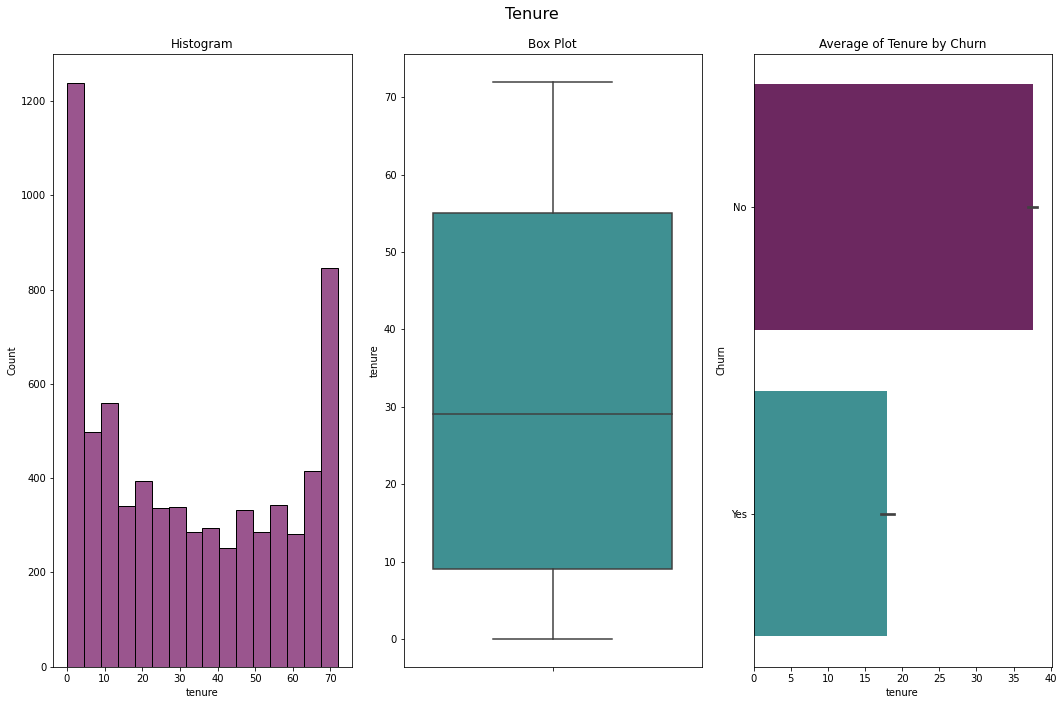

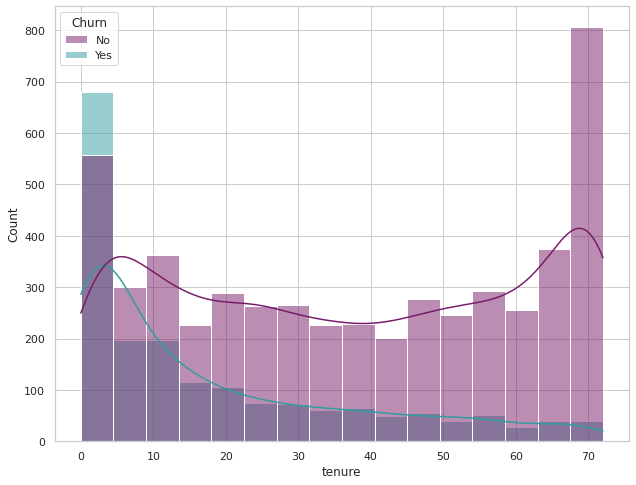

######################################################################
        count       mean        std    min      1%     5%    10%     50%  \
Churn                                                                      
No     5174.0  61.265124  31.092648  18.25  19.150  19.60  19.95  64.425   
Yes    1869.0  74.441332  24.666053  18.85  19.484  20.62  34.70  79.650   

           90%       95%      99%     max  
Churn                                      
No     103.135  108.4175  115.100  118.75  
Yes    101.770  105.6100  111.132  118.35  
######################################################################


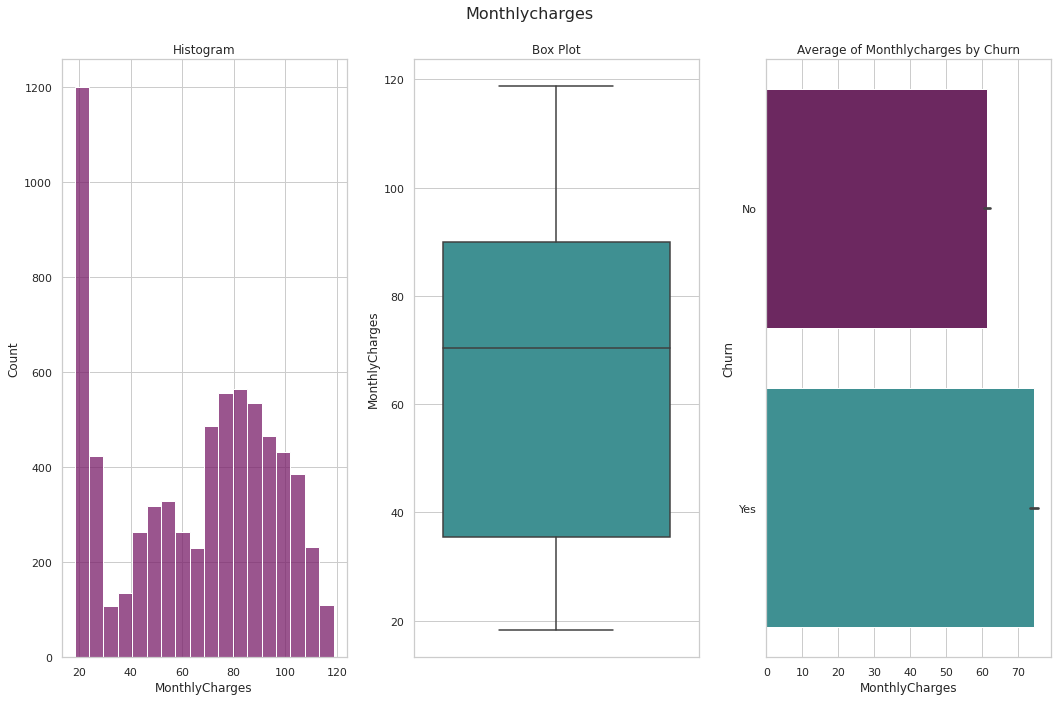

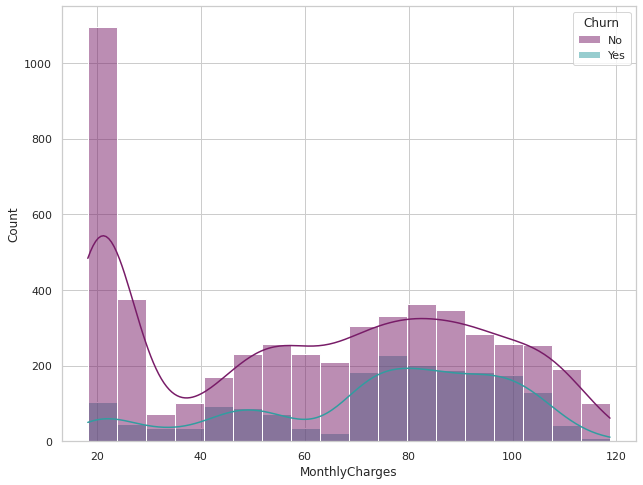

######################################################################
        count         mean          std    min      1%     5%     10%  \
Churn                                                                   
No     5163.0  2555.344141  2329.456984  18.80  19.900  61.06  158.47   
Yes    1869.0  1531.796094  1890.822994  18.85  19.834  36.12   59.64   

           50%      90%       95%       99%      max  
Churn                                                 
No     1683.60  6293.10  7128.395  8138.040  8672.45  
Yes     703.55  4556.79  5890.050  7436.802  8684.80  
######################################################################


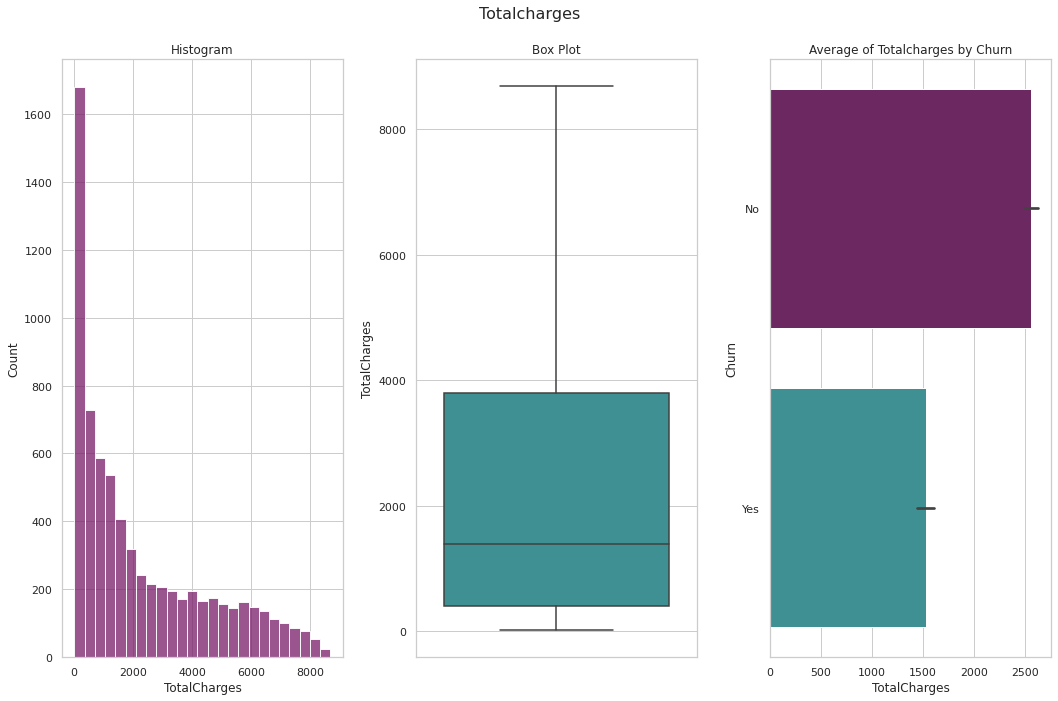

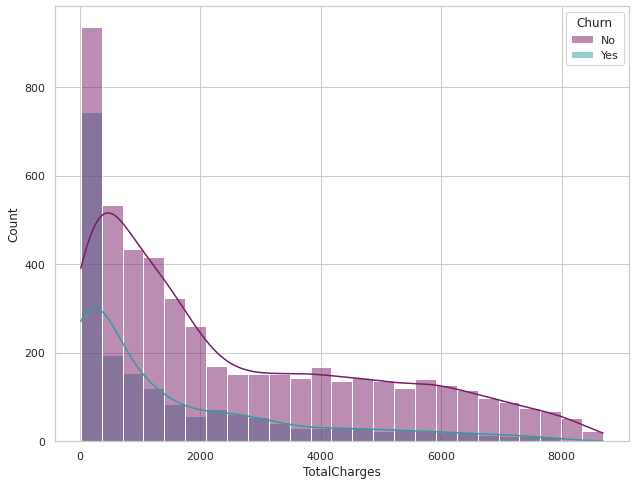

In [8]:
def num_summary(dataframe, col_name, target):
    quantiles = [.01, .05, .1, .5, .9, .95, .99]
    print("#" * 70)
    print(dataframe.groupby(target)[col_name].describe(percentiles=quantiles))
    print("#" * 70)

    plt.figure(figsize=(15, 10))
    plt.suptitle(col_name.capitalize(), size=16)
    plt.subplot(1, 3, 1)
    plt.title("Histogram")
    sns.histplot(dataframe[col_name], color=num_feat_colors[0])

    plt.subplot(1, 3, 2)
    plt.title("Box Plot")
    sns.boxplot(data=dataframe, y=col_name, color=num_feat_colors[1])

    plt.subplot(1, 3, 3)
    sns.barplot(data=dataframe, x=col_name, y=target, palette=num_feat_colors, estimator=np.mean)
    plt.title(f"Average of {col_name.capitalize()} by {target.capitalize()}")
    plt.tight_layout(pad=1.5)
    plt.show(block=True)

def num_features_hist(df, column_name,i,hue):
    plt.figure(figsize=(35, 20))
    sns.set(font_scale = 1)
    sns.set_style("whitegrid")
    sns.set_palette("bright")
    plt.subplots_adjust(hspace=0.5)
    plt.subplot(2,3,i)
    sns.histplot(data=df, x=column_name, hue=hue,kde=True,palette=num_feat_colors)
    plt.show(block=True)
    


for i, col_name in enumerate(num_cols):
    num_summary(df, col_name, "Churn")
    num_features_hist(df,col_name,i+1,'Churn')

####################################################################################################
Male      3555
Female    3488
Name: gender, dtype: int64
####################################################################################################


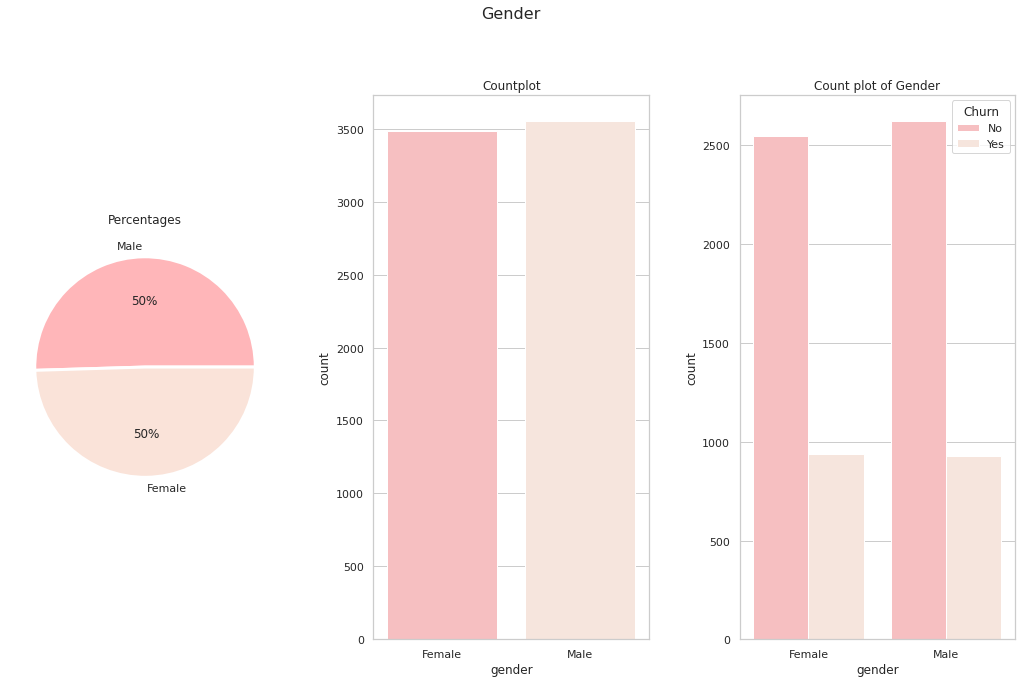

####################################################################################################
No     3641
Yes    3402
Name: Partner, dtype: int64
####################################################################################################


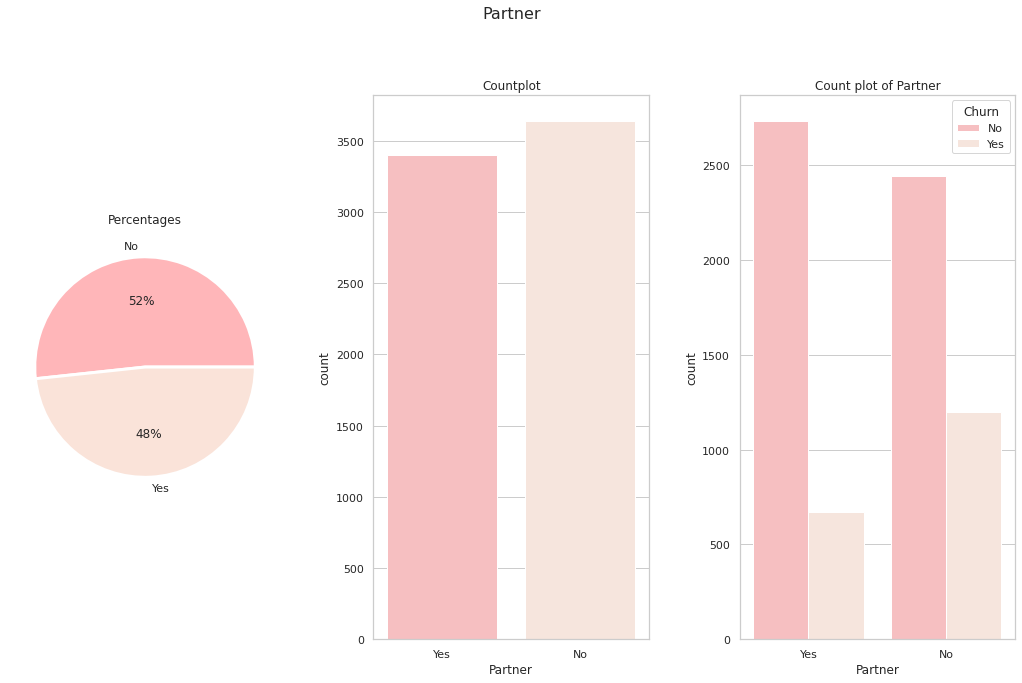

####################################################################################################
No     4933
Yes    2110
Name: Dependents, dtype: int64
####################################################################################################


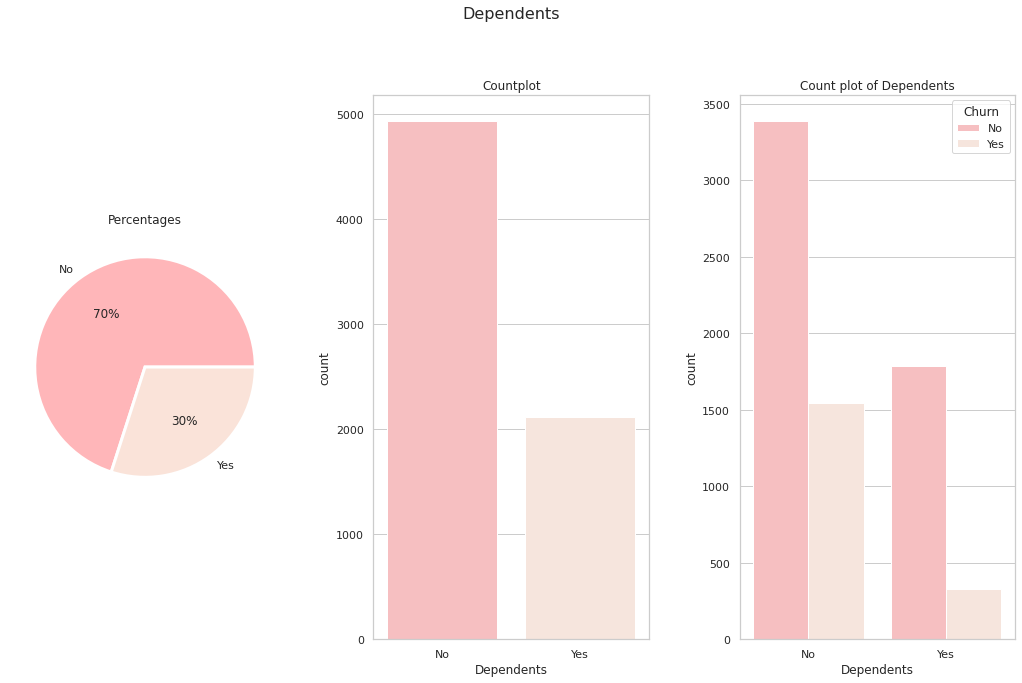

####################################################################################################
Yes    6361
No      682
Name: PhoneService, dtype: int64
####################################################################################################


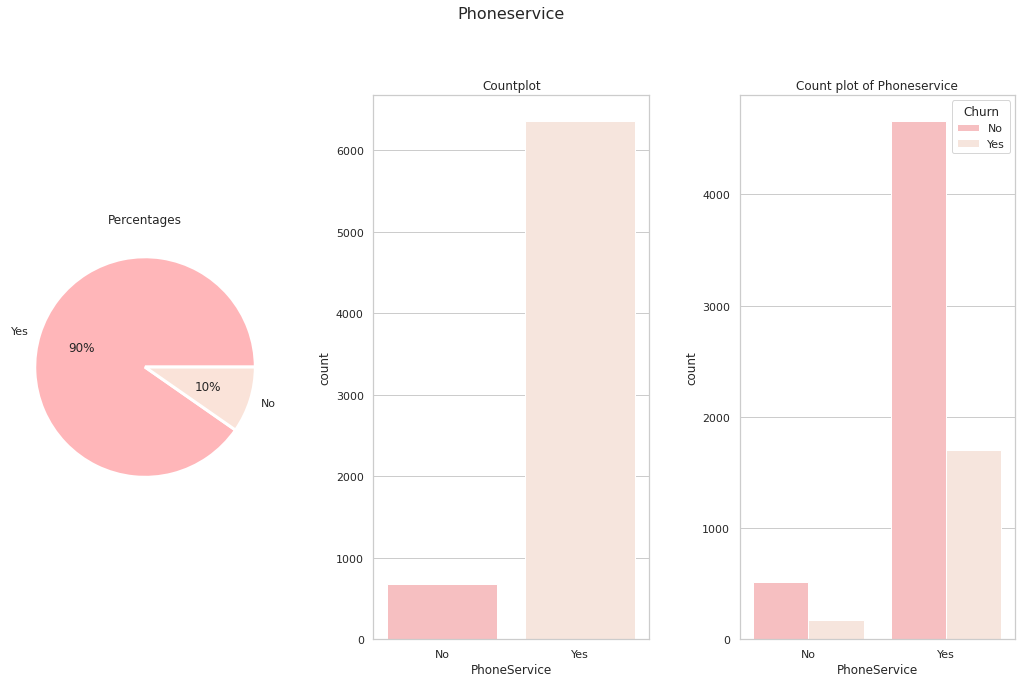

####################################################################################################
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
####################################################################################################


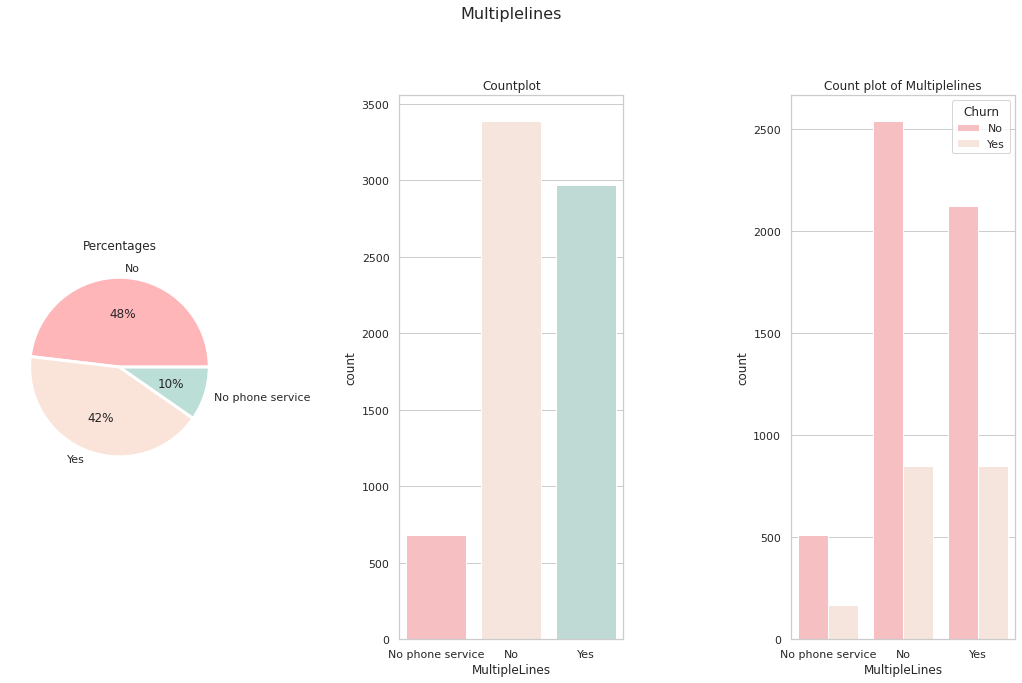

####################################################################################################
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
####################################################################################################


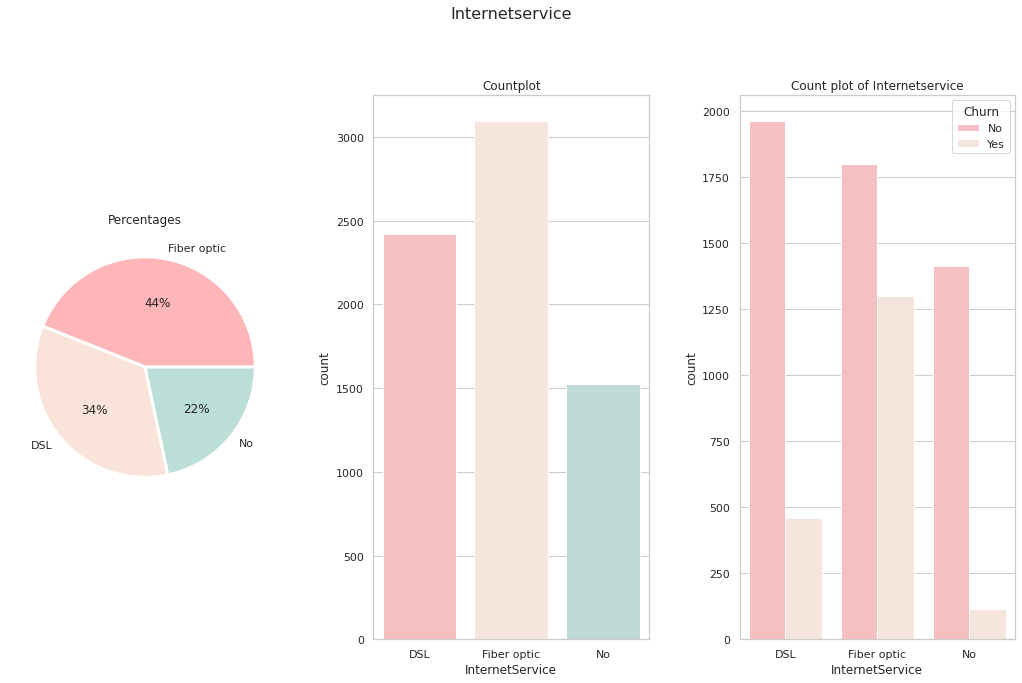

####################################################################################################
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
####################################################################################################


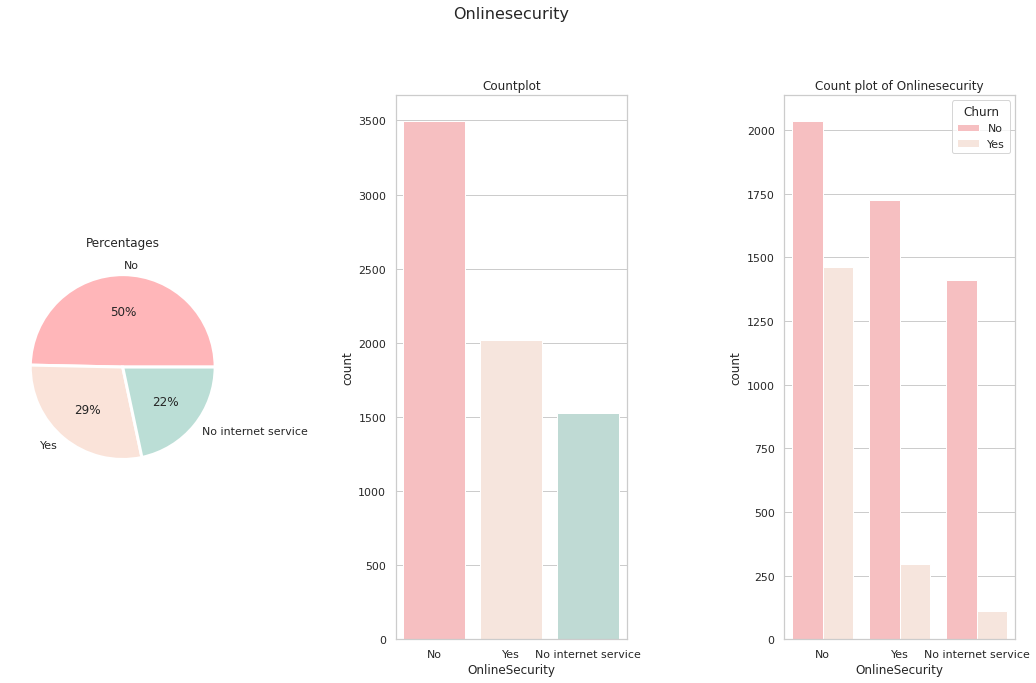

####################################################################################################
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
####################################################################################################


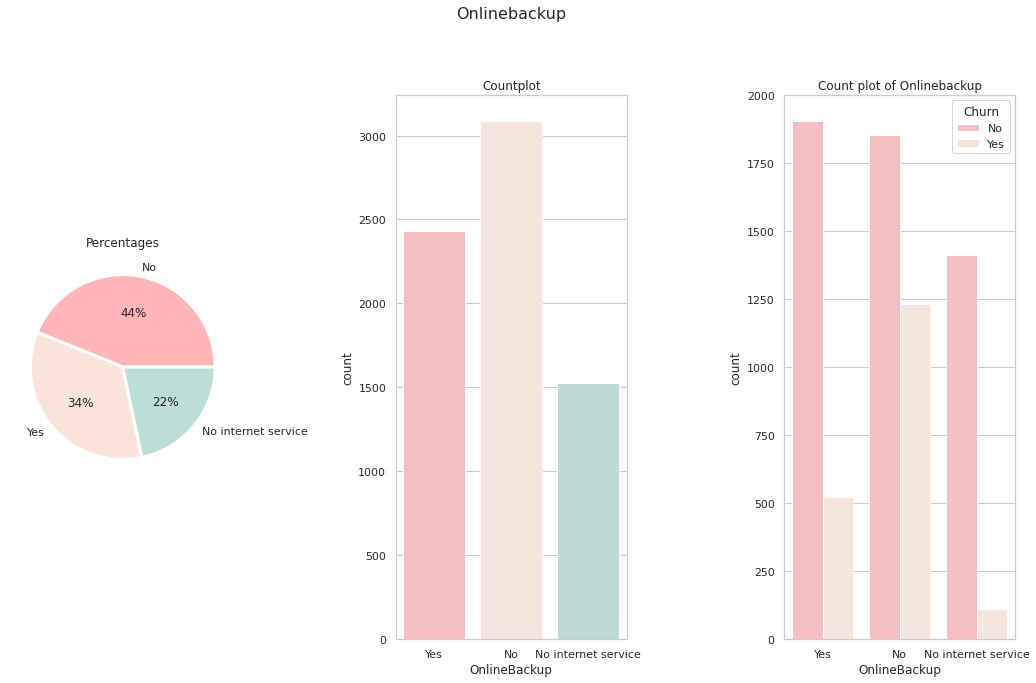

####################################################################################################
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64
####################################################################################################


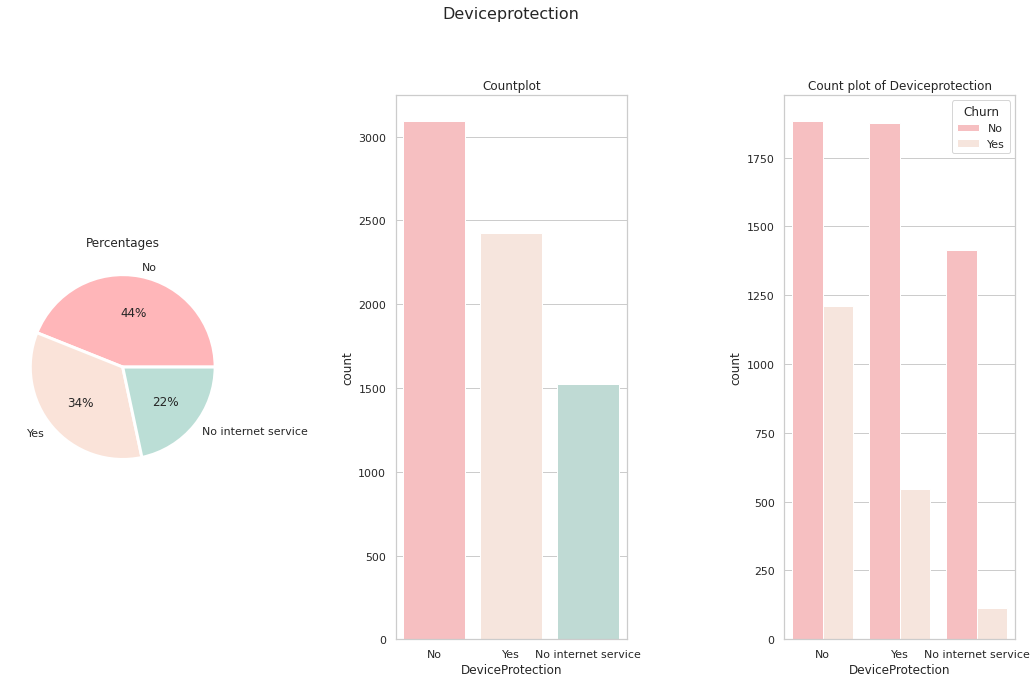

####################################################################################################
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64
####################################################################################################


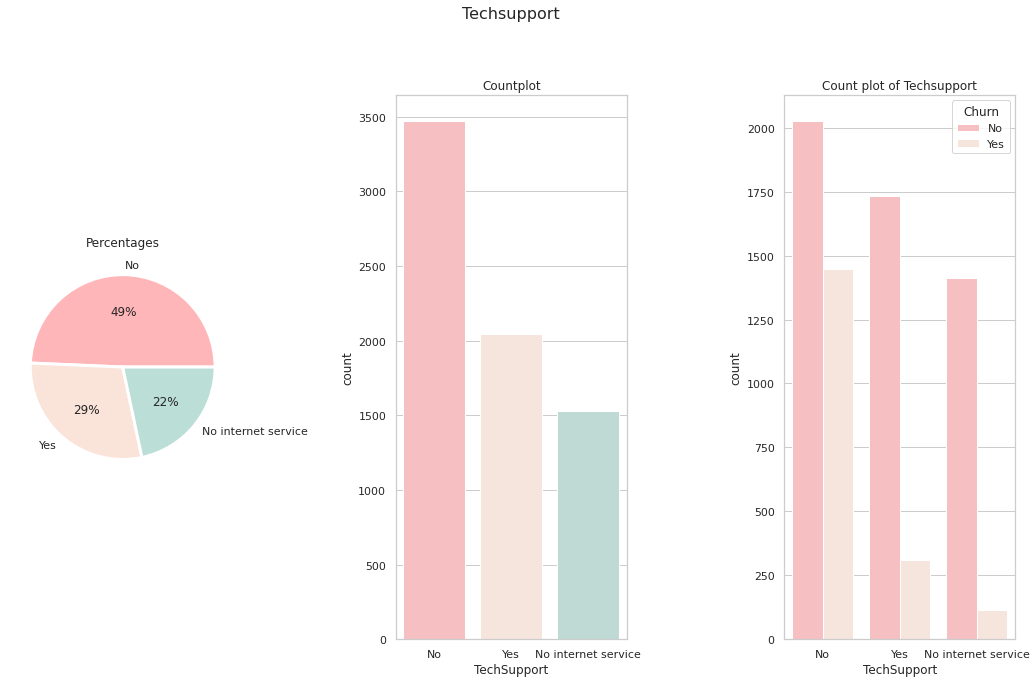

####################################################################################################
No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64
####################################################################################################


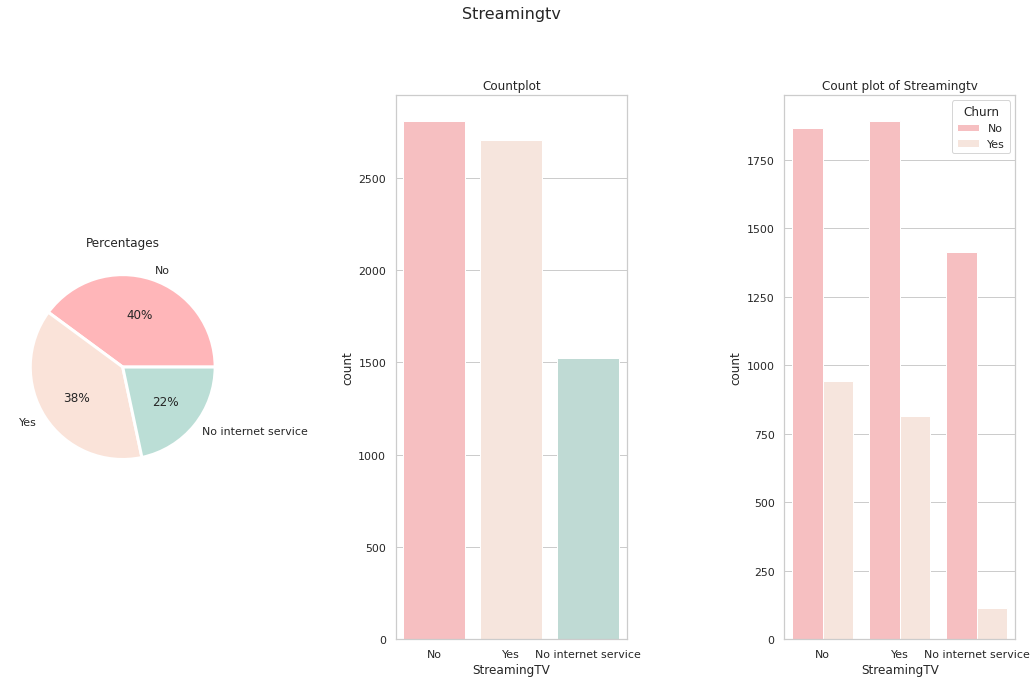

####################################################################################################
No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64
####################################################################################################


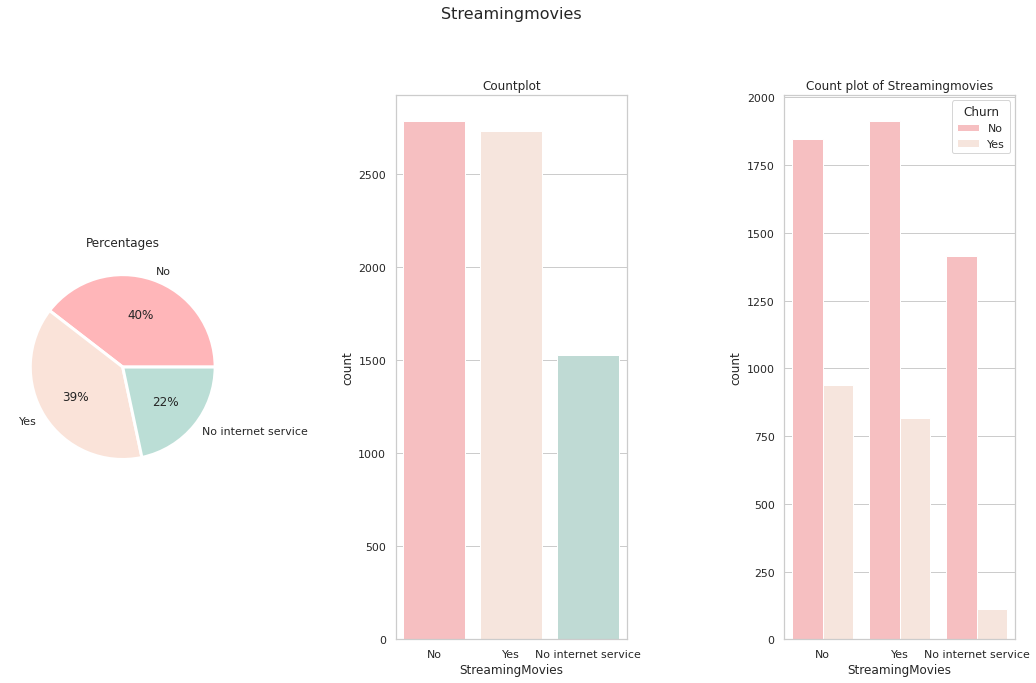

####################################################################################################
Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, dtype: int64
####################################################################################################


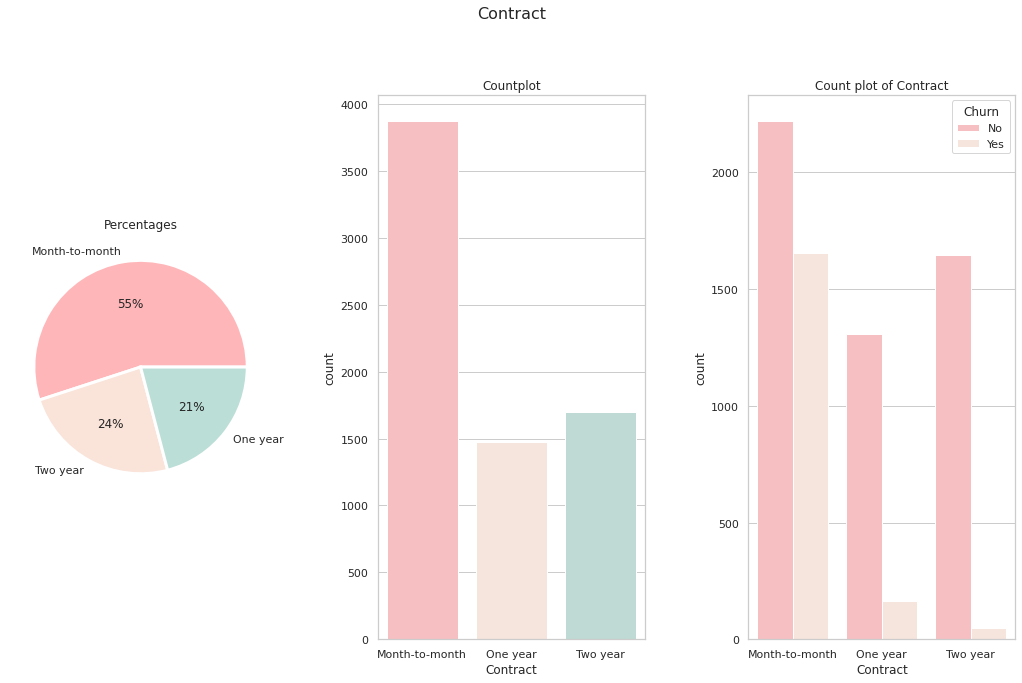

####################################################################################################
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
####################################################################################################


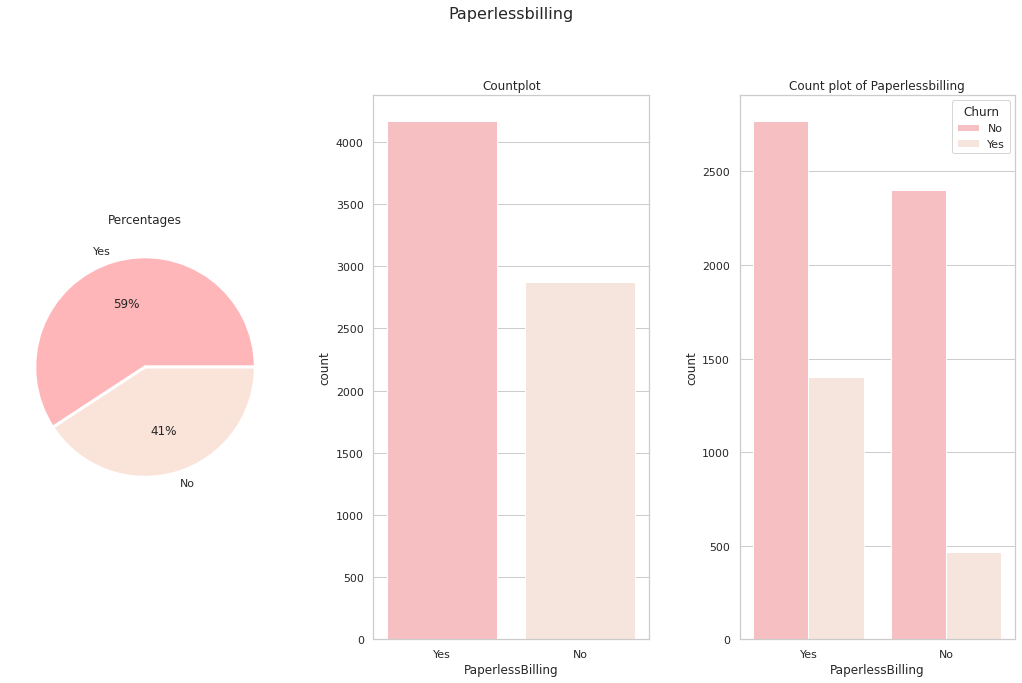

####################################################################################################
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
####################################################################################################


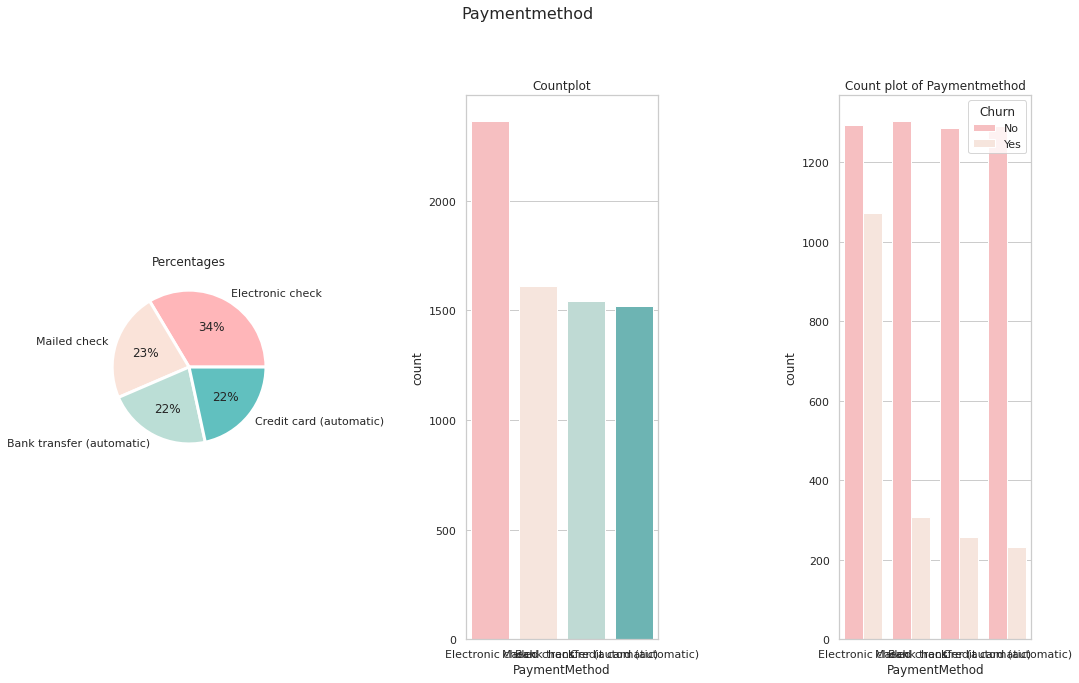

####################################################################################################
No     5174
Yes    1869
Name: Churn, dtype: int64
####################################################################################################


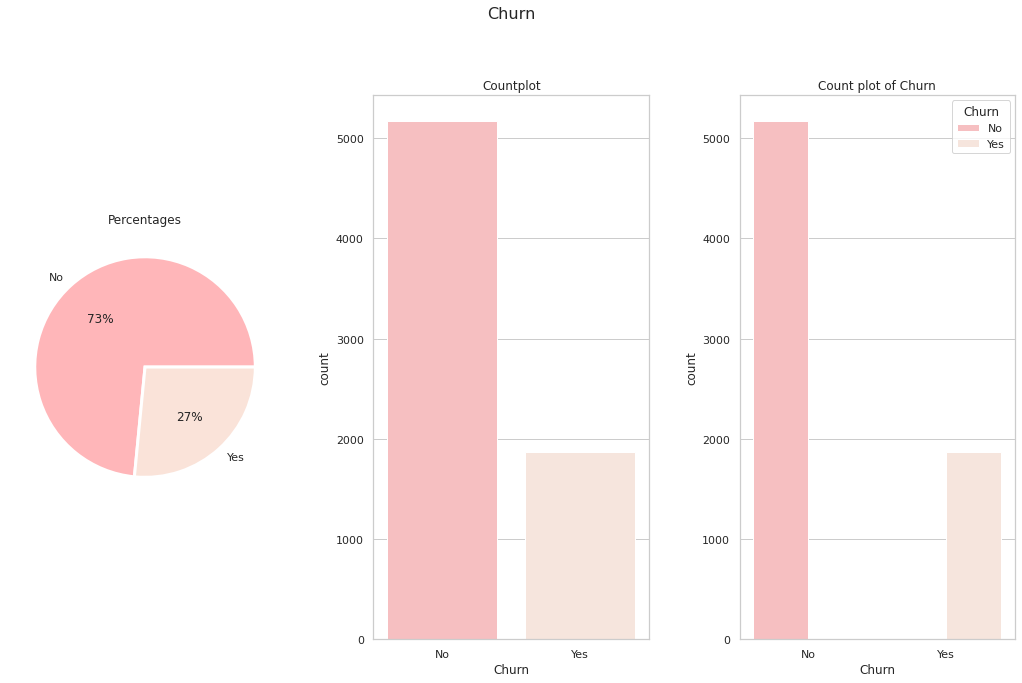

####################################################################################################
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
####################################################################################################


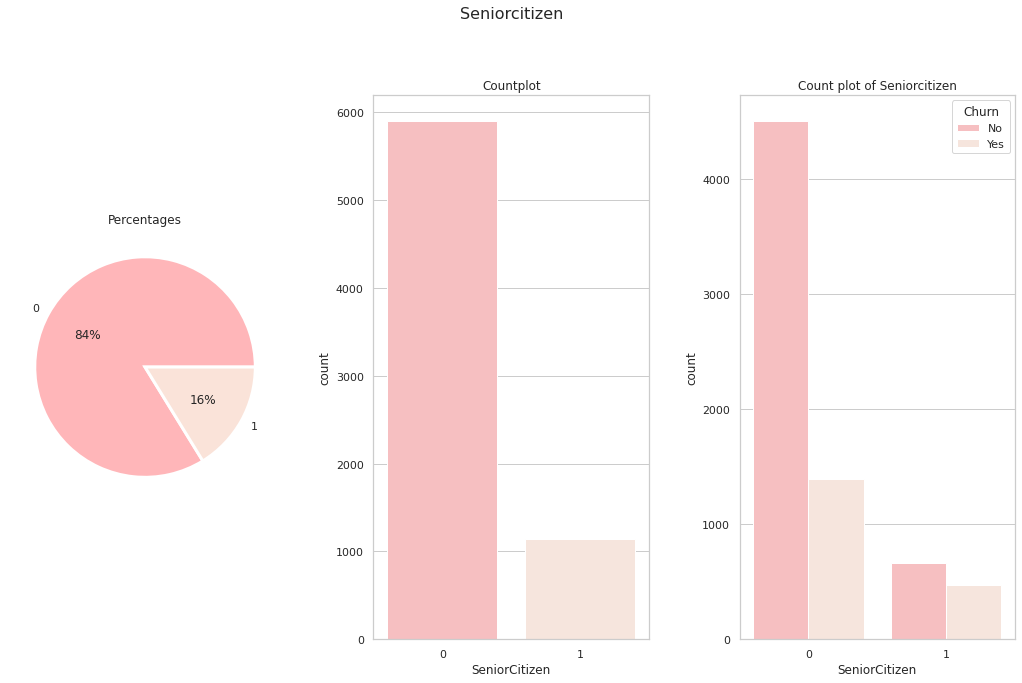

In [9]:
def cat_plots(dataframe, cat_col, target):
    print("".center(100, "#"))
    print(dataframe[cat_col].value_counts())
    print("".center(100, "#"))

    plt.figure(figsize=(15, 10))
    sns.set_style("whitegrid")
    plt.suptitle(cat_col.capitalize(), size=16)
    plt.subplot(1, 3, 1)
    plt.title("Percentages")
    plt.pie(dataframe[cat_col].value_counts().values.tolist(),
            labels=dataframe[cat_col].value_counts().keys().tolist(),
            labeldistance=1.1,
            wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
            colors=cat_feat_colors,
            autopct='%1.0f%%')

    

    plt.subplot(1, 3, 2)
    plt.title("Countplot")
    sns.countplot(data=dataframe, x=cat_col, palette=cat_feat_colors)
    plt.tight_layout(pad=3)

    

    plt.subplot(1, 3, 3)
    sns.countplot(data=dataframe, x=cat_col, hue=target, palette=cat_feat_colors)
    plt.title(f"Count plot of {cat_col.capitalize()}")
    plt.show(block=True)

        
for col in cat_cols:
    cat_plots(df, col, "Churn")


# Summary of EDA
- The dataset is unbalanced. So predictions will be biased towards Non Churn customers.
- Customers who have a Partner churned less as compared to those has'nt a Partner.
- Similarly churning is low who has Dependents
- Customers without telephone service have a lower churn rate
- Customers with dsl internet service have a lower churn rate
- Customers with protection service(OnlineBackup, OnlineSecurity, DeviceProtection), the churning rate is lower.
- Customers who pay monthly have a higher churn rate.
- Most of the customers whose payment method is electronic check have been lost

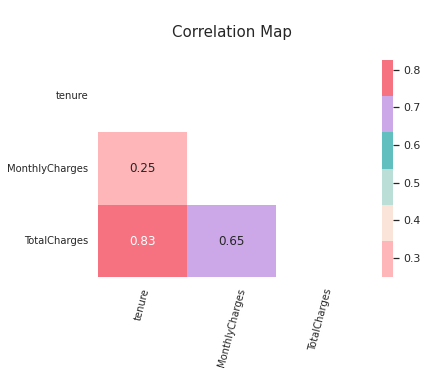

In [10]:
corr = df[num_cols].corr()
corr_matrix = corr.abs()
msk = np.triu(corr)
sns.heatmap(corr, mask=msk, annot=True, linecolor="black", cmap=cat_feat_colors)
plt.yticks(rotation=0, size=10)
plt.xticks(rotation=75, size=10)
plt.title('\nCorrelation Map\n', size=15)
plt.show(block=True)

- There seems to be a high correlation between totalcharges and tenure variables.

In [11]:
df[df["TotalCharges"].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


- Missing values in the total charges variable show that customers have not paid yet. We will fill these observations with 0 in the data preprocessing part.

# Data PreProcessing

In [12]:
def outlier_threshold(dataframe, variable, q1=.1, q3=.9):
    quartile1 = dataframe[variable].quantile(q1)
    quartile3 = dataframe[variable].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_threshold(dataframe, variable)
    len_outlier = len(dataframe.loc[dataframe[variable] > up_limit]) + len(
        dataframe.loc[dataframe[variable] < low_limit])
    print(f"{variable} variable has {len_outlier} outliers")
    dataframe[variable] = dataframe[variable].apply(
        lambda x: round(up_limit) if x > up_limit else (round(low_limit) if x < low_limit else x))

In [13]:
def preprocessing(dataframe):
    dataframe["TotalCharges"].fillna(0, inplace=True)
    # New Features
    
    dataframe["New_Customer_Age"] = pd.cut(dataframe["tenure"], labels=["0-1 Year", "1-2 Year", "2-3 Year", "3-4 Year", 
                                                      "4-5 Year", "5-6 Year"], bins=[-1, 12, 24, 36, 48, 60, 73])
    
    dataframe["New_Customer_Commitment"] = dataframe["Contract"].apply(lambda x: 1 if x not in "Month-to-month" else 0)
    
    dataframe["New_Auto_Payment"] = dataframe["PaymentMethod"].apply(lambda x: 1 if x.__contains__("automatic") else 0)
    
    dataframe["New_Average_Charges"] = dataframe["TotalCharges"] / (dataframe["tenure"] + 0.01)
    
    dataframe['NEW_TotalServices'] = (dataframe[['PhoneService', 'InternetService', 'OnlineSecurity',
                               'OnlineBackup', 'DeviceProtection', 'TechSupport',
                               'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)
    
    dataframe["NEW_Protection"] = dataframe.apply(lambda x: 1 if (x["OnlineBackup"] == "Yes")
                                                  and (x["OnlineSecurity"] == "Yes") and(x["DeviceProtection"] == "Yes") 
                                                  and (x["TechSupport"] == "Yes") else 0, axis=1)
    
    dataframe["New_Streaming"] = dataframe.apply(lambda x: 1 if (x["StreamingTV"] == "Yes") 
                                                 and (x["StreamingMovies"] == "Yes") else 0, axis=1)
    
    cat_cols, num_cols, cat_but_car = grab_col_names(df)
    # Let's drop cardinal features
    dataframe.drop(cat_but_car, axis=1, inplace=True)
    dataframe["Churn"] = np.where(dataframe["Churn"]=="Yes", 1, 0)
    # Outliers
    for col in num_cols:
        replace_with_thresholds(dataframe, col)
        
    return dataframe

In [14]:
df["Churn"].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

In [15]:
tmp = df.copy()
tmp = preprocessing(tmp)
tmp.head()

~~~~~~~~~~~~~~~~~~~~~~~~~~ RESULT ~~~~~~~~~~~~~~~~~~~~~~~~~~ 

cat_cols: 17
num_cols: 3
cat_but_car: 1
num_but_cat: 1 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
tenure variable has 0 outliers
MonthlyCharges variable has 0 outliers
TotalCharges variable has 0 outliers


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,MonthlyCharges,TotalCharges,Churn,New_Customer_Age,New_Customer_Commitment,New_Auto_Payment,New_Average_Charges,NEW_TotalServices,NEW_Protection,New_Streaming
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,29.85,29.85,0,0-1 Year,0,0,29.554455,1,0,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,56.95,1889.50,0,2-3 Year,1,0,55.557189,3,0,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,53.85,108.15,1,0-1 Year,0,0,53.805970,3,0,0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,42.30,1840.75,0,3-4 Year,1,1,40.896467,3,0,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,70.70,151.65,1,0-1 Year,0,0,75.447761,1,0,0


In [16]:
X = tmp.drop(["Churn"], axis=1)
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = tmp["Churn"]
X.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,New_Customer_Commitment,New_Auto_Payment,New_Average_Charges,NEW_TotalServices,NEW_Protection,New_Streaming,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,New_Customer_Age_1-2 Year,New_Customer_Age_2-3 Year,New_Customer_Age_3-4 Year,New_Customer_Age_4-5 Year,New_Customer_Age_5-6 Year
0,-0.439916,-1.277445,-1.160323,-0.992611,-0.904184,-0.878028,-1.158561,-1.052777,-0.267404,-0.616578,...,-0.562975,0.829798,-0.525047,1.406418,-0.544807,-0.412466,-0.366000,-0.348308,-0.366,-0.499645
1,-0.439916,0.066327,-0.259629,-0.172165,1.105970,-0.878028,-0.299254,0.031958,-0.267404,-0.616578,...,-0.562975,-1.205113,-0.525047,-0.711026,1.835513,-0.412466,2.732242,-0.348308,-0.366,-0.499645
2,-0.439916,-1.236724,-0.362660,-0.958066,-0.904184,-0.878028,-0.357126,0.031958,-0.267404,-0.616578,...,-0.562975,0.829798,-0.525047,-0.711026,1.835513,-0.412466,-0.366000,-0.348308,-0.366,-0.499645
3,-0.439916,0.514251,-0.746535,-0.193672,1.105970,1.138916,-0.783744,0.031958,-0.267404,-0.616578,...,-0.562975,-1.205113,-0.525047,-0.711026,-0.544807,-0.412466,-0.366000,2.871025,-0.366,-0.499645
4,-0.439916,-1.236724,0.197365,-0.938874,-0.904184,-0.878028,0.358065,-1.052777,-0.267404,-0.616578,...,-0.562975,0.829798,-0.525047,1.406418,-0.544807,-0.412466,-0.366000,-0.348308,-0.366,-0.499645


In [17]:
y.head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [18]:
print(X.shape)
print(y.shape)

(7043, 41)
(7043,)


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, random_state=42)

In [20]:
y_train.value_counts()

0    3892
1    1390
Name: Churn, dtype: int64

In [21]:
y_test.value_counts()

0    1282
1     479
Name: Churn, dtype: int64

# Base Models

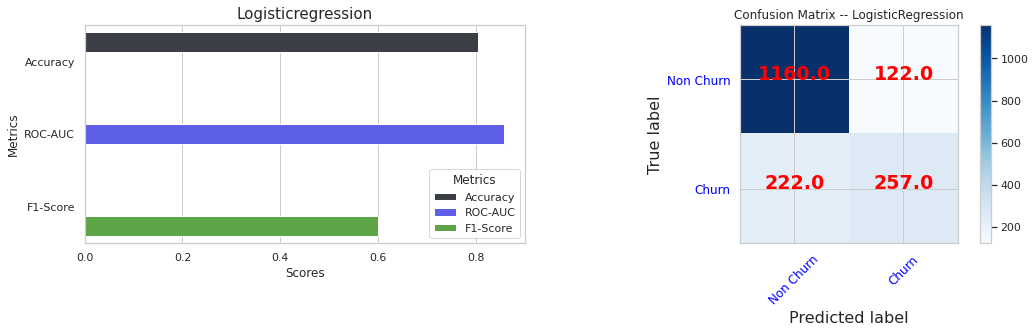

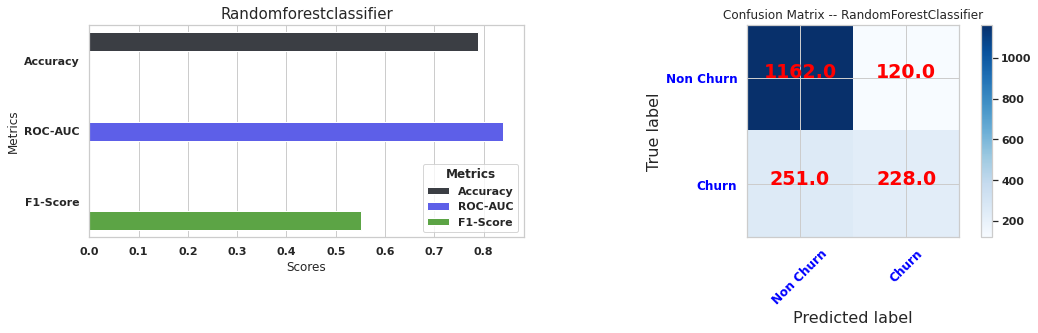

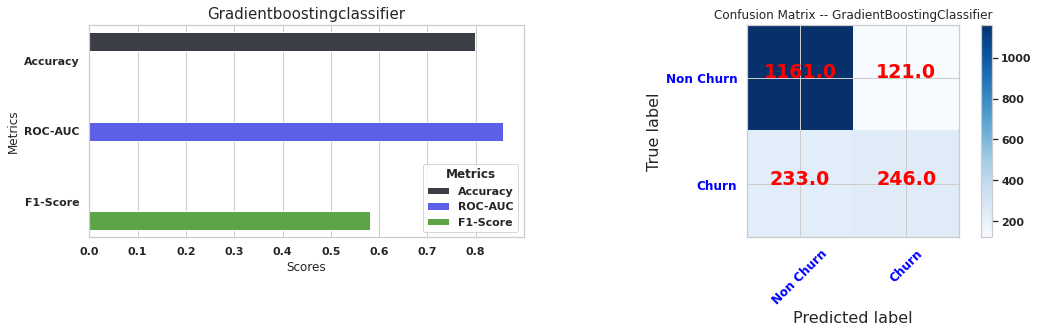

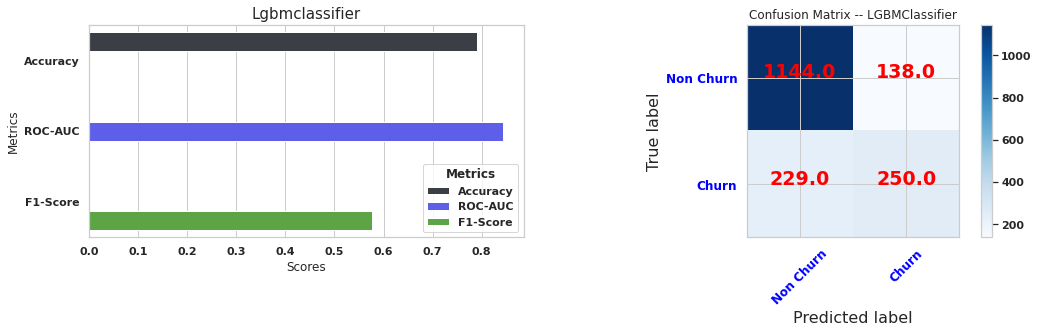

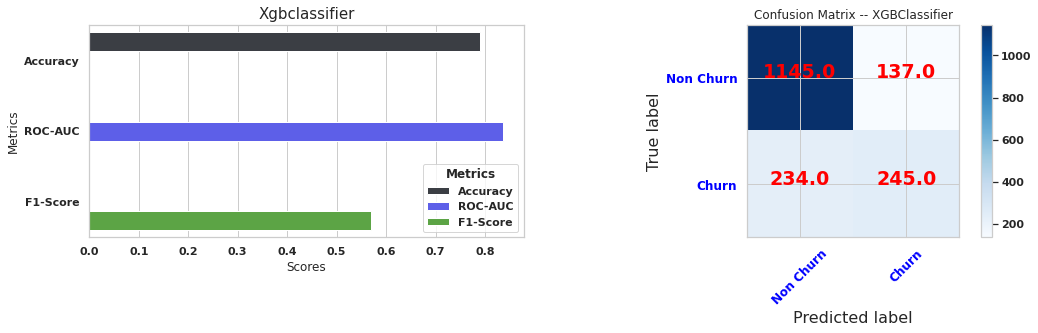

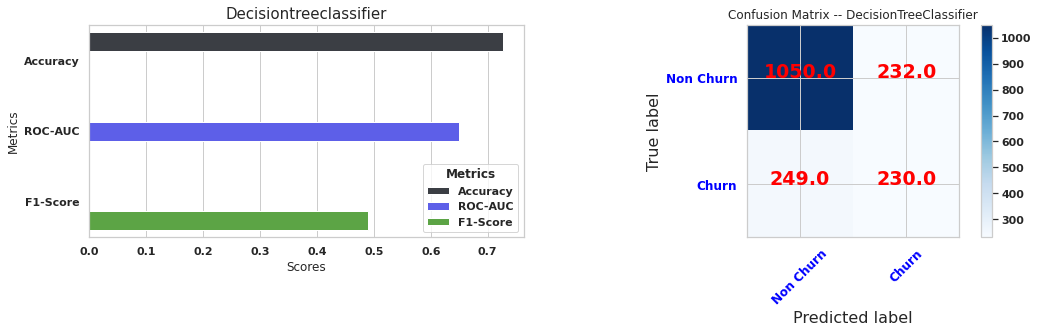

In [22]:
def base_models(model):
    
    y_pred = model.fit(X_train, y_train).predict(X_test)
    Accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    f1 = f1_score(y_test, y_pred)
    mt_dataframe = pd.DataFrame({'Scores': [Accuracy, roc_auc, f1],
                            'Metrics': ['Accuracy',
                                        'ROC-AUC',
                                        'F1-Score']})
    
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title(str(model).split("(")[0].capitalize(), size=15)
    sns.barplot(data=mt_dataframe, x="Scores", y="Metrics", hue="Metrics", palette=metric_colors)
    
    plt.subplot(1, 2, 2)
    
    plt.rcParams.update({'font.size': 19})
    plt.imshow(confusion_matrix(y_test, y_pred), interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix -- {str(model).split('(')[0]}")
    plt.colorbar()
    tick_marks = np.arange(len(y_train.unique()))
    plt.xticks(tick_marks, ["Non Churn", "Churn"], rotation=45,fontsize=12,color="blue")
    plt.yticks(tick_marks, ["Non Churn", "Churn"], fontsize=12,color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = confusion_matrix(y_test, y_pred).max()
    for i, j in itertools.product(range(confusion_matrix(y_test, y_pred).shape[0]), range(confusion_matrix(y_test, y_pred).shape[1])):
        plt.text(j, i, format(confusion_matrix(y_test, y_pred)[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label',fontdict={'size':'16'})
    plt.xlabel('Predicted label',fontdict={'size':'16'})
    plt.tight_layout()
    
    plt.show(block=True)

ml_models = [  
               LogisticRegression(random_state = 42),
               RandomForestClassifier(random_state = 42),
               GradientBoostingClassifier(random_state = 42),
               LGBMClassifier(random_state = 42),
               XGBClassifier(random_state = 42),
               DecisionTreeClassifier(random_state = 42)
            ]

for model in ml_models:
    base_models(model)

## SMOTE OverSampling
Generating minority class synthetic samples to prevent overfitting.
- First, a random sample from the minority class is selected.
- Then, k nearest neighbors are found for this sample.
- One of the K nearest neighbors is randomly selected and a synthetic sample is formed by combining it with the randomly selected sample from the minority class and forming a line segment in the feature space.

In [23]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
# After smote oversampling
y_train.value_counts()

1    3892
0    3892
Name: Churn, dtype: int64

# Hyperparameter Optimization

In [24]:
knn_params = {'metric': ['manhattan'], 
              'n_neighbors': [2], 
              'weights': ['distance']}

cart_params = {'max_depth': [14], 
               'min_samples_split': [3]}

rf_params = {'max_depth': [None], 
             'max_features': ['sqrt'], 
             'min_samples_split': [2], 
             'n_estimators': [100]}

xgboost_params = {'colsample_bytree':[ 0.5], 
                  'learning_rate': [0.01], 
                  'max_depth': [12], 
                  'n_estimators': [400]}

lightgbm_params = {'colsample_bytree':[ 0.7], 
                   'learning_rate': [0.01], 
                   'max_depth': [-1], 
                   'n_estimators': [500], 
                   'num_leaves': [63]}

classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]


def hyperparameter_optimization(X, y, cv=10, scoring="f1"):
    print("Hyperparameter Optimization....")
    best_models = {}
    
    for name, classifier, params in classifiers:
        print(f"#################### {name} ####################")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)

        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

best_models = hyperparameter_optimization(X_train, y_train)

Hyperparameter Optimization....
#################### KNN ####################
f1 (Before): 0.8244
f1 (After): 0.8647
KNN best params: {'metric': 'manhattan', 'n_neighbors': 2, 'weights': 'distance'}

#################### CART ####################
f1 (Before): 0.7936
f1 (After): 0.8076
CART best params: {'max_depth': 14, 'min_samples_split': 3}

#################### RF ####################
f1 (Before): 0.8592
f1 (After): 0.8589
RF best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}

#################### XGBoost ####################
f1 (Before): 0.8321
f1 (After): 0.8519
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.01, 'max_depth': 12, 'n_estimators': 400}

#################### LightGBM ####################
f1 (Before): 0.8403
f1 (After): 0.843
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 63}



In [25]:
best_models

{'KNN': KNeighborsClassifier(metric='manhattan', n_neighbors=2, weights='distance'),
 'CART': DecisionTreeClassifier(max_depth=14, min_samples_split=3),
 'RF': RandomForestClassifier(max_features='sqrt'),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.5, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss', gamma=None,
               gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.01, max_bin=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, n_estimators=400, n_jobs=None,
               num_parallel_tree=None, predictor=None, random_state=None,
               reg_alpha=None, reg_lambda=None, ...),
 'LightGBM': LGBMClassifier(c

# Final Models

In [26]:
knn_model = best_models["KNN"].fit(X_train, y_train)
cv_result = cross_validate(knn_model,
                          X_train, y_train,
                          cv=10,
                          scoring=["accuracy", "f1", "roc_auc"])

print(cv_result["test_accuracy"].mean())
print(cv_result["test_f1"].mean())
print(cv_result["test_roc_auc"].mean())

0.8572886932360057
0.8646950502821801
0.8934541793392514


In [27]:
cart_model = best_models["CART"].fit(X_train, y_train)
cv_result = cross_validate(cart_model,
                          X_train, y_train,
                          cv=10,
                          scoring=["accuracy", "f1", "roc_auc"])

print(cv_result["test_accuracy"].mean())
print(cv_result["test_f1"].mean())
print(cv_result["test_roc_auc"].mean())

0.8090017192960456
0.8075069201013655
0.8235658073794221


In [28]:
rf_model = best_models["RF"].fit(X_train, y_train)
cv_result = cross_validate(rf_model,
                          X_train, y_train,
                          cv=10,
                          scoring=["accuracy", "f1", "roc_auc"])

print(cv_result["test_accuracy"].mean())
print(cv_result["test_f1"].mean())
print(cv_result["test_roc_auc"].mean())

0.8615493134365793
0.8573570466580941
0.9354612117659877


In [29]:
xg_model = best_models["XGBoost"].fit(X_train, y_train)
cv_result = cross_validate(xg_model,
                          X_train, y_train,
                          cv=10,
                          scoring=["accuracy", "f1", "roc_auc"])

print(cv_result["test_accuracy"].mean())
print(cv_result["test_f1"].mean())
print(cv_result["test_roc_auc"].mean())

0.8601415366744656
0.8518566749648407
0.942594620130851


In [30]:
lgbm_model = best_models["LightGBM"].fit(X_train, y_train)
cv_result = cross_validate(lgbm_model,
                          X_train, y_train,
                          cv=10,
                          scoring=["accuracy", "f1", "roc_auc"])

print(cv_result["test_accuracy"].mean())
print(cv_result["test_f1"].mean())
print(cv_result["test_roc_auc"].mean())

0.8538502661443879
0.8430336663145788
0.9397726593780347


# Confusion Matrix

In [31]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.rcParams.update({'font.size': 19})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontdict={'size':'16'})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=12,color="blue")
    plt.yticks(tick_marks, classes,fontsize=12,color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label',fontdict={'size':'16'})
    plt.xlabel('Predicted label',fontdict={'size':'16'})
    plt.tight_layout()
    plt.show(block=True)


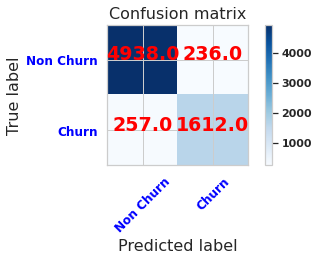

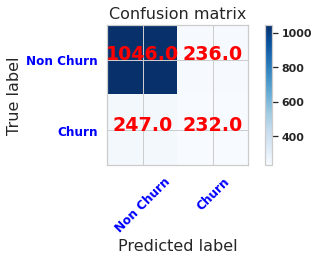

In [32]:
y_pred = knn_model.predict(X)
plot_confusion_matrix(confusion_matrix(y, y_pred=y_pred), classes=["Non Churn", "Churn"],
                      title='Confusion matrix')

y_pred = knn_model.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=["Non Churn", "Churn"],
                      title='Confusion matrix')

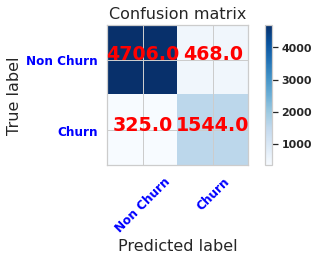

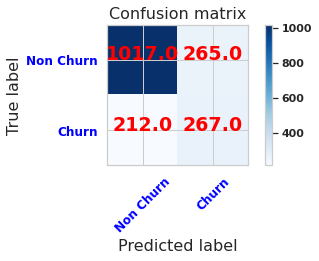

In [33]:
y_pred = cart_model.predict(X)
plot_confusion_matrix(confusion_matrix(y, y_pred=y_pred), classes=["Non Churn", "Churn"],
                      title='Confusion matrix')

y_pred = cart_model.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=["Non Churn", "Churn"],
                      title='Confusion matrix')

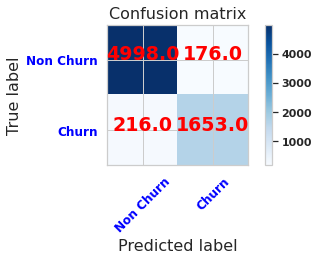

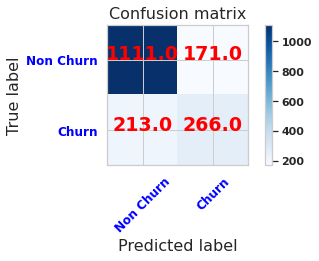

In [34]:
y_pred = rf_model.predict(X)
plot_confusion_matrix(confusion_matrix(y, y_pred=y_pred), classes=["Non Churn", "Churn"],
                      title='Confusion matrix')

y_pred = rf_model.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=["Non Churn", "Churn"],
                      title='Confusion matrix')

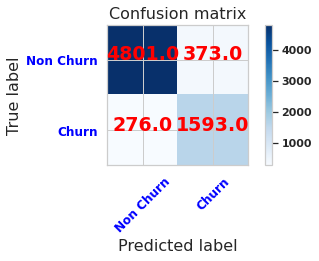

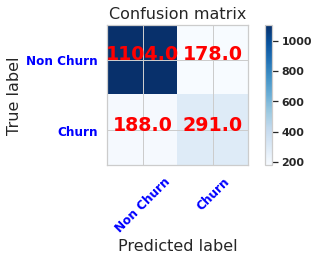

In [35]:
y_pred = xg_model.predict(X)
plot_confusion_matrix(confusion_matrix(y, y_pred=y_pred), classes=["Non Churn", "Churn"],
                      title='Confusion matrix')

y_pred = xg_model.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=["Non Churn", "Churn"],
                      title='Confusion matrix')

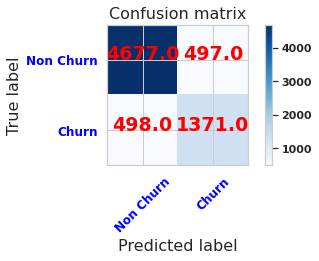

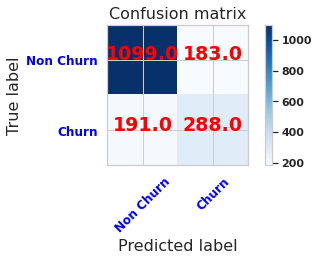

In [36]:
y_pred = lgbm_model.predict(X)
plot_confusion_matrix(confusion_matrix(y, y_pred=y_pred), classes=["Non Churn", "Churn"],
                      title='Confusion matrix')

y_pred = lgbm_model.predict(X_test)
plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=["Non Churn", "Churn"],
                      title='Confusion matrix')

# Feature Importances

    Value                                Feature
1    4410                                 tenure
2    3727                         MonthlyCharges
6    3496                    New_Average_Charges
3    3304                           TotalCharges
7    1354                      NEW_TotalServices
10   1144                            gender_Male
32   1097                   PaperlessBilling_Yes
11    985                            Partner_Yes
21    922                       OnlineBackup_Yes
19    912                     OnlineSecurity_Yes
15    867                      MultipleLines_Yes
12    790                         Dependents_Yes
25    723                        TechSupport_Yes
23    656                   DeviceProtection_Yes
34    603         PaymentMethod_Electronic check
16    585            InternetService_Fiber optic
0     550                          SeniorCitizen
29    544                    StreamingMovies_Yes
33    465  PaymentMethod_Credit card (automatic)
4     433           

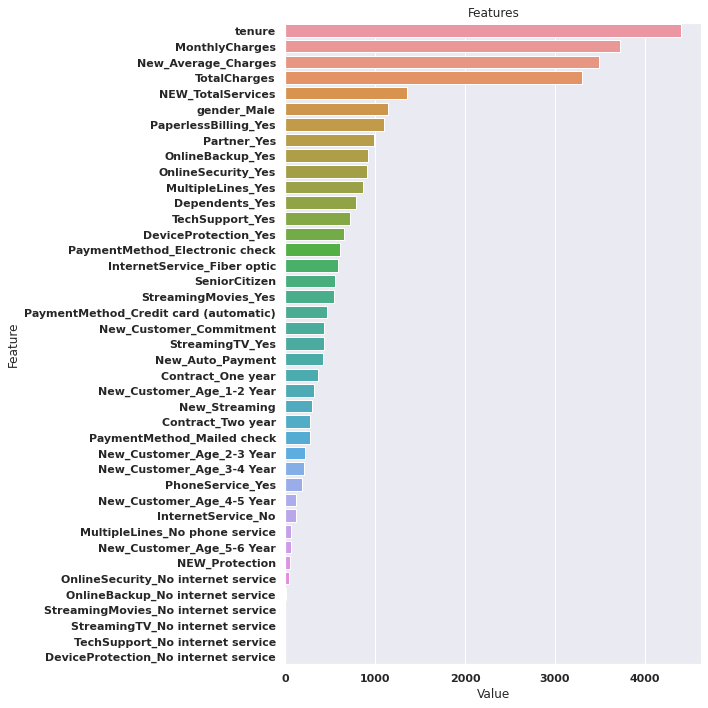

In [37]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value", ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')


plot_importance(lgbm_model, X)